# 1. Required Packages

In [1]:
import math

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt

import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import csv
import torchvision.models as models
import torchvision

import time

from sklearn.metrics import confusion_matrix, roc_curve, auc

from torch.nn.functional import softmax, interpolate
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image

# from torchcam.methods import SmoothGradCAMpp, LayerCAM
# from torchcam.utils import overlay_mask

import random

In [2]:
# always check your version
print(torch.__version__)
# check if gpu/cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

2.0.1
Using device: cuda


# 2. Overview:

1. Function implementation

2. Model Training

3. Model Fine-tuning

4. Model Testing

5. Model Comparison

6. Interpretation of results



# 3. Function implementation

## 3.1 Dataset Class

In [3]:
class CustomDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

## 3.2 Define a CNN model class [4 marks]

Create a simple model class using a combination of:
- Convolution layers
- Activation functions (e.g. ReLU)
- Maxpooling layers
- Fully connected layers 
- Loss function
- Optimiser

In [54]:
# TO COMPLETE
# define a CNN Model class
class SimpleCNN(nn.Sequential): # Same as nn.Model
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=8, kernel_size=2, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.relu1 = nn.ReLU()
        self.pooling1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=8,out_channels=16, kernel_size=2, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.pooling2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=16,out_channels=32, kernel_size=2, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.relu3 = nn.ReLU()
        self.pooling3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(in_channels=32,out_channels=64, kernel_size=2, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()
        self.pooling4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(in_channels=64,out_channels=128, kernel_size=2, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.relu5 = nn.ReLU()
        self.pooling5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv6 = nn.Conv2d(in_channels=128,out_channels=256, kernel_size=2, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.relu6 = nn.ReLU()
        self.pooling6 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(p=0.1)
        self.relu7 = nn.ReLU()
        self.fc1 = nn.Linear(4096, 64)
        self.dropout2 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(64, 4)
        
    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pooling1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pooling2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pooling3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pooling4(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.pooling5(x)

        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.pooling6(x)

        x = self.flatten(x)
        # x = self.dropout1(x)
        x = self.fc1(x)
        # x = self.dropout2(x)
        x = self.relu7(x)
        x = self.fc2(x)

        return x


# 4. Model Training

In [4]:
# dataset path
ROOT = "./mushroom_dataset_4_classes/"
root_dir = ROOT
# direct read classes
classes = os.listdir(root_dir)
img_paths = []
labels = []

for class_idx, class_name in enumerate(sorted(classes)):
    class_dir = os.path.join(root_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img_paths.append(img_path)
        labels.append(class_idx)

print(len(img_paths))
print(len(labels))

8781
8781


In [19]:
for index in range(4):
    class_name = classes[index]
    print(index, class_name)

0 conditionally_edible
1 deadly
2 edible
3 poisonous


In [5]:
# train val split(ratio = 8:2)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    img_paths, labels, test_size=0.2, stratify=labels, random_state=42) # 42 is answer to all...
print(train_paths.__len__())
print(val_paths.__len__())
print(train_labels.__len__())
print(val_labels.__len__())

7024
1757
7024
1757


In [21]:
# No augmentation on validation dataset
val_transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor()
])

# With augmentation on trainning dataset
train_transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomRotation(10),  # 随机旋转（在-10到+10度之间）
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # 随机调整亮度、对比度、饱和度和色调
    transforms.ToTensor()
])

train_dataset = CustomDataset(
    train_paths,
    train_labels,
    transform=train_transform
)

val_dataset = CustomDataset(
    val_paths,
    val_labels,
    transform=val_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False
)

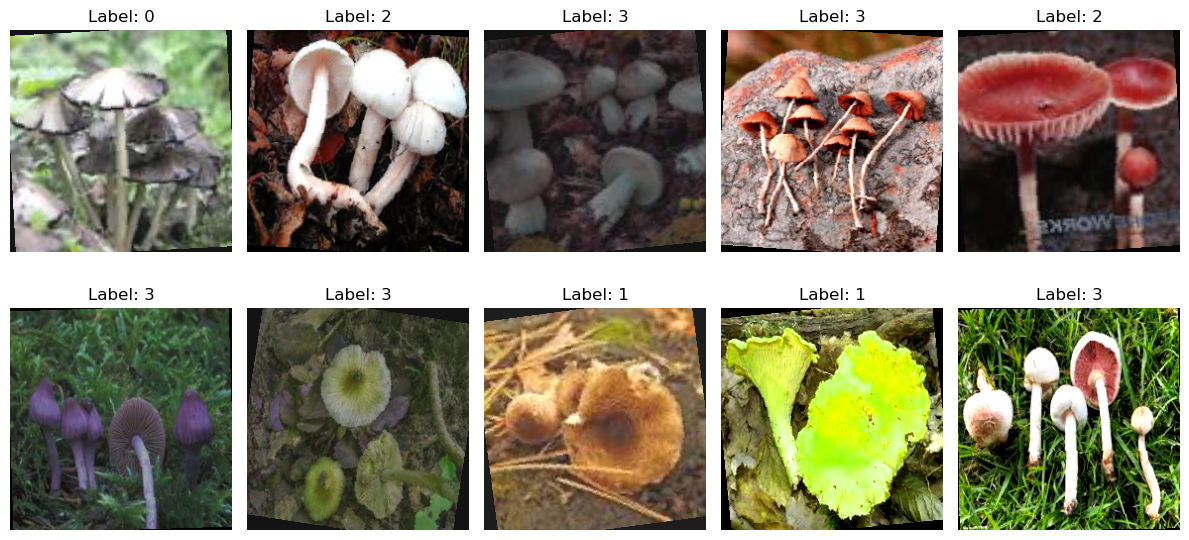

In [22]:
# display some samples
# get one batch
data, labels = next(iter(train_loader))
# data, labels = next(iter(val_loader))

# choose first 10 images
images = data[:10]
labels = labels[:10]

# better for display for no aug
images = images.permute(0, 2, 3, 1)

# draw
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(images[i])
    axs[i].set_title('Label: {}'.format(labels[i]))
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [8]:
# Define top-*k* accuracy 
def topk_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [9]:
# plot training progress
def plot_training_progress(results_path):
    data = torch.load(results_path)
    fig, ax1 = plt.subplots()
    plt.plot(data["train_loss"], 'r', label = 'train_loss')
    plt.plot(data["val_loss"], 'm', label = 'val_loss')
    plt.legend(loc='upper right')
    plt.xlabel('epoch')
    plt.ylabel('loss')

    ax2=ax1.twinx()
    plt.plot(data["train_accuracy"], 'g', label = 'train_accuracy')
    plt.plot(data["val_accuracy"], 'b', label = 'val_accuracy')
    plt.legend(loc='lower right')
    ax2.set_ylabel('accuracy')

    plt.show()

In [61]:
# time recording start
start_time = time.time()

#TO COMPLETE --> Running you CNN model class
ResultPath = "./results/"
results_path = ResultPath + 'simplecnn-nodp-epochs20-adam-lr0.001-noaug-bs128128-3060-top1.pt'
nepochs = 20
SimpleCNN = SimpleCNN()
SimpleCNN.to(device)

# initialise ndarray to store the loss and accuracy in each epoch (on the training data)
train_loss = np.zeros(nepochs)
train_accuracy = np.zeros(nepochs)
val_loss = np.zeros(nepochs)
val_accuracy = np.zeros(nepochs)

# Use a loss function and optimiser provided as part of PyTorch.
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(SimpleCNN.parameters(), lr=0.001)

for epoch in range(nepochs):  # loop over the dataset multiple times

    # initialise variables for mean loss calculation
    running_loss = 0.0
    n = 0
    correct = 0
    total = 0

    # train
    SimpleCNN.train()
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients to remove accumulated gradient from a previous iteration.
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = SimpleCNN(inputs)

        # calculate top-k accuracy
        correct_k = topk_accuracy(outputs, labels, topk=(1,))[0]

        # accumulate accuracy for this batch
        num_correct_k = correct_k.item() / 100 * labels.size(0)
        correct += num_correct_k

        total += labels.size(0)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # accumulate loss and increment minibatches
        running_loss += loss.item()
        n += 1    

    # record the mean loss for this epoch and show progress
    train_loss[epoch] = running_loss / n
    train_accuracy[epoch] = correct / total
    
    # reset variables for mean loss calculation
    running_loss = 0.0
    n = 0
    correct = 0
    total = 0

    # val
    SimpleCNN.eval()
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward and accumulate loss
            outputs = SimpleCNN(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            n += 1

            # calculate top-k accuracy
            correct_k = topk_accuracy(outputs, labels, topk=(1,))[0]

            num_correct_k = correct_k.item() / 100 * labels.size(0)
            correct += num_correct_k
            
            total += labels.size(0)

    # calculate test accuracy and loss
    val_loss[epoch] = running_loss / n
    val_accuracy[epoch] = correct / total

    print(f"epoch: {epoch+1} training loss: {train_loss[epoch]: .3f} training accuracy: {train_accuracy[epoch]: .1%}  val loss: {val_loss[epoch]: .3f} val accuracy: {val_accuracy[epoch]: .1%}")

end_time = time.time()
total_time = end_time - start_time
print(f"Training took {total_time:.2f} seconds.")

# save network parameters and four features
data = {
    'state_dict': SimpleCNN.state_dict(),
    'train_loss': train_loss,
    'train_accuracy': train_accuracy,
    'val_loss': val_loss,
    'val_accuracy': val_accuracy,
    'total_time': total_time
}
torch.save(data, results_path)

epoch: 1 training loss:  1.196 training accuracy:  51.2%  val loss:  1.082 val accuracy:  55.3%
epoch: 2 training loss:  1.070 training accuracy:  54.9%  val loss:  1.072 val accuracy:  53.8%
epoch: 3 training loss:  1.049 training accuracy:  55.7%  val loss:  1.073 val accuracy:  52.9%
epoch: 4 training loss:  1.011 training accuracy:  57.3%  val loss:  1.076 val accuracy:  55.3%
epoch: 5 training loss:  0.982 training accuracy:  58.8%  val loss:  1.036 val accuracy:  57.2%
epoch: 6 training loss:  0.948 training accuracy:  60.4%  val loss:  1.082 val accuracy:  57.8%
epoch: 7 training loss:  0.896 training accuracy:  63.9%  val loss:  1.081 val accuracy:  51.6%
epoch: 8 training loss:  0.841 training accuracy:  65.8%  val loss:  1.044 val accuracy:  58.3%
epoch: 9 training loss:  0.755 training accuracy:  69.5%  val loss:  1.126 val accuracy:  50.3%
epoch: 10 training loss:  0.642 training accuracy:  75.3%  val loss:  1.183 val accuracy:  54.4%
epoch: 11 training loss:  0.556 trainin

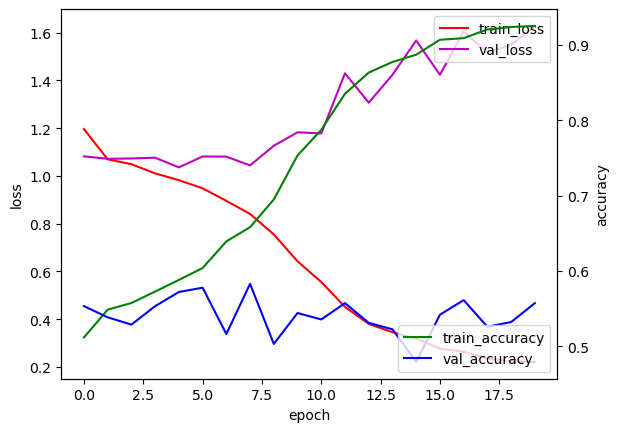

In [62]:
plot_training_progress(results_path)

In [10]:
ResNeXt = models.resnext50_32x4d(pretrained=True)

for param in ResNeXt.parameters():
    param.requires_grad = False

num_classes = 4
ResNeXt.fc = nn.Linear(ResNeXt.fc.in_features, num_classes)

# time recording start
start_time = time.time()

#TO COMPLETE --> Running you CNN model class
ResultPath = "./results/"
results_path = ResultPath + 'resnext-epochs20-adam-lr0.001-noaug-bs128128-3060-top1.pt'
nepochs = 20
ResNeXt.to(device)

# initialise ndarray to store the loss and accuracy in each epoch (on the training data)
train_loss = np.zeros(nepochs)
train_accuracy = np.zeros(nepochs)
val_loss = np.zeros(nepochs)
val_accuracy = np.zeros(nepochs)

# Use a loss function and optimiser provided as part of PyTorch.
loss_fn = nn.CrossEntropyLoss()
# Only last fc layer?
optimizer = torch.optim.Adam(ResNeXt.fc.parameters(), lr=0.001)

for epoch in range(nepochs):  # loop over the dataset multiple times

    # initialise variables for mean loss calculation
    running_loss = 0.0
    n = 0
    correct = 0
    total = 0

    # train
    ResNeXt.train()
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients to remove accumulated gradient from a previous iteration.
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = ResNeXt(inputs)

        # calculate top-k accuracy
        correct_k = topk_accuracy(outputs, labels, topk=(1,))[0]

        # accumulate accuracy for this batch
        num_correct_k = correct_k.item() / 100 * labels.size(0)
        correct += num_correct_k

        total += labels.size(0)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # accumulate loss and increment minibatches
        running_loss += loss.item()
        n += 1    

    # record the mean loss for this epoch and show progress
    train_loss[epoch] = running_loss / n
    train_accuracy[epoch] = correct / total
    
    # reset variables for mean loss calculation
    running_loss = 0.0
    n = 0
    correct = 0
    total = 0

    # val
    ResNeXt.eval()
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward and accumulate loss
            outputs = ResNeXt(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            n += 1

            # calculate top-k accuracy
            correct_k = topk_accuracy(outputs, labels, topk=(1,))[0]

            num_correct_k = correct_k.item() / 100 * labels.size(0)
            correct += num_correct_k
            
            total += labels.size(0)

    # calculate test accuracy and loss
    val_loss[epoch] = running_loss / n
    val_accuracy[epoch] = correct / total

    print(f"epoch: {epoch+1} training loss: {train_loss[epoch]: .3f} training accuracy: {train_accuracy[epoch]: .1%}  val loss: {val_loss[epoch]: .3f} val accuracy: {val_accuracy[epoch]: .1%}")

end_time = time.time()
total_time = end_time - start_time
print(f"Training took {total_time:.2f} seconds.")

# save network parameters and four features
data = {
    'state_dict': ResNeXt.state_dict(),
    'train_loss': train_loss,
    'train_accuracy': train_accuracy,
    'val_loss': val_loss,
    'val_accuracy': val_accuracy,
    'total_time': total_time
}
torch.save(data, results_path)

c:\Users\Peng Miao\anaconda3\envs\MushroomSafe\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Peng Miao\anaconda3\envs\MushroomSafe\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch: 1 training loss:  1.063 training accuracy:  56.1%  val loss:  0.996 val accuracy:  59.2%
epoch: 2 training loss:  0.956 training accuracy:  60.3%  val loss:  0.986 val accuracy:  57.7%
epoch: 3 training loss:  0.931 training accuracy:  61.6%  val loss:  0.960 val accuracy:  60.5%
epoch: 4 training loss:  0.894 training accuracy:  63.2%  val loss:  0.946 val accuracy:  59.9%
epoch: 5 training loss:  0.882 training accuracy:  63.5%  val loss:  0.955 val accuracy:  60.7%
epoch: 6 training loss:  0.867 training accuracy:  64.0%  val loss:  0.953 val accuracy:  59.7%
epoch: 7 training loss:  0.867 training accuracy:  64.2%  val loss:  0.948 val accuracy:  58.7%
epoch: 8 training loss:  0.849 training accuracy:  65.2%  val loss:  0.943 val accuracy:  61.0%
epoch: 9 training loss:  0.836 training accuracy:  65.7%  val loss:  0.938 val accuracy:  60.7%
epoch: 10 training loss:  0.834 training accuracy:  65.9%  val loss:  0.955 val accuracy:  61.2%
epoch: 11 training loss:  0.830 trainin

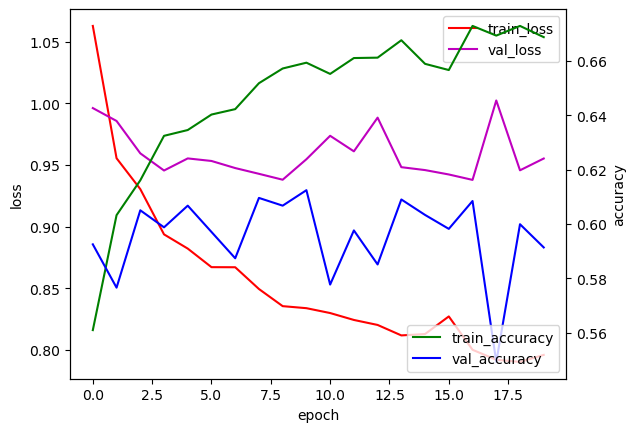

In [11]:
plot_training_progress(results_path)

Add weights to loss function

In [27]:
total_samples = 420 + 1190 + 2475 + 4696

proportion_conditional_edible = 420 / total_samples
proportion_deadly = 1190 / total_samples
proportion_edible = 2475 / total_samples
proportion_poisonous = 4696 / total_samples

weight_conditional_edible = 1 / proportion_conditional_edible
weight_deadly = 1 / proportion_deadly
weight_edible = 1 / proportion_edible
weight_poisonous = 1 / proportion_poisonous

In [32]:
ResNeXt = models.resnext50_32x4d(pretrained=True)

for param in ResNeXt.parameters():
    param.requires_grad = False

num_classes = 4
ResNeXt.fc = nn.Linear(ResNeXt.fc.in_features, num_classes)

# time recording start
start_time = time.time()

#TO COMPLETE --> Running you CNN model class
ResultPath = "./results/"
results_path = ResultPath + 'resnext-epochs20-adam-weightloss-lr0.0005-aug-bs128128-3060-top1.pt'
nepochs = 20
ResNeXt.to(device)

# initialise ndarray to store the loss and accuracy in each epoch (on the training data)
train_loss = np.zeros(nepochs)
train_accuracy = np.zeros(nepochs)
val_loss = np.zeros(nepochs)
val_accuracy = np.zeros(nepochs)

class_weights = torch.tensor([weight_conditional_edible, weight_deadly, weight_edible, weight_poisonous]).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
# Only last fc layer?
optimizer = torch.optim.Adam(ResNeXt.fc.parameters(), lr=0.0005)

for epoch in range(nepochs):  # loop over the dataset multiple times

    # initialise variables for mean loss calculation
    running_loss = 0.0
    n = 0
    correct = 0
    total = 0

    # train
    ResNeXt.train()
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients to remove accumulated gradient from a previous iteration.
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = ResNeXt(inputs)

        # calculate top-k accuracy
        correct_k = topk_accuracy(outputs, labels, topk=(1,))[0]

        # accumulate accuracy for this batch
        num_correct_k = correct_k.item() / 100 * labels.size(0)
        correct += num_correct_k

        total += labels.size(0)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # accumulate loss and increment minibatches
        running_loss += loss.item()
        n += 1    

    # record the mean loss for this epoch and show progress
    train_loss[epoch] = running_loss / n
    train_accuracy[epoch] = correct / total
    
    # reset variables for mean loss calculation
    running_loss = 0.0
    n = 0
    correct = 0
    total = 0

    # val
    ResNeXt.eval()
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward and accumulate loss
            outputs = ResNeXt(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            n += 1

            # calculate top-k accuracy
            correct_k = topk_accuracy(outputs, labels, topk=(1,))[0]

            num_correct_k = correct_k.item() / 100 * labels.size(0)
            correct += num_correct_k
            
            total += labels.size(0)

    # calculate test accuracy and loss
    val_loss[epoch] = running_loss / n
    val_accuracy[epoch] = correct / total

    print(f"epoch: {epoch+1} training loss: {train_loss[epoch]: .3f} training accuracy: {train_accuracy[epoch]: .1%}  val loss: {val_loss[epoch]: .3f} val accuracy: {val_accuracy[epoch]: .1%}")

end_time = time.time()
total_time = end_time - start_time
print(f"Training took {total_time:.2f} seconds.")

# save network parameters and four features
data = {
    'state_dict': ResNeXt.state_dict(),
    'train_loss': train_loss,
    'train_accuracy': train_accuracy,
    'val_loss': val_loss,
    'val_accuracy': val_accuracy,
    'total_time': total_time
}
torch.save(data, results_path)

epoch: 1 training loss:  1.321 training accuracy:  32.9%  val loss:  1.240 val accuracy:  44.3%
epoch: 2 training loss:  1.202 training accuracy:  41.0%  val loss:  1.193 val accuracy:  47.4%
epoch: 3 training loss:  1.154 training accuracy:  44.6%  val loss:  1.162 val accuracy:  41.1%
epoch: 4 training loss:  1.122 training accuracy:  44.5%  val loss:  1.136 val accuracy:  38.7%
epoch: 5 training loss:  1.113 training accuracy:  44.5%  val loss:  1.190 val accuracy:  24.6%
epoch: 6 training loss:  1.120 training accuracy:  43.5%  val loss:  1.132 val accuracy:  43.7%
epoch: 7 training loss:  1.083 training accuracy:  45.6%  val loss:  1.113 val accuracy:  45.7%
epoch: 8 training loss:  1.089 training accuracy:  46.2%  val loss:  1.106 val accuracy:  42.6%
epoch: 9 training loss:  1.064 training accuracy:  46.7%  val loss:  1.144 val accuracy:  39.1%
epoch: 10 training loss:  1.065 training accuracy:  45.7%  val loss:  1.101 val accuracy:  40.3%
epoch: 11 training loss:  1.061 trainin

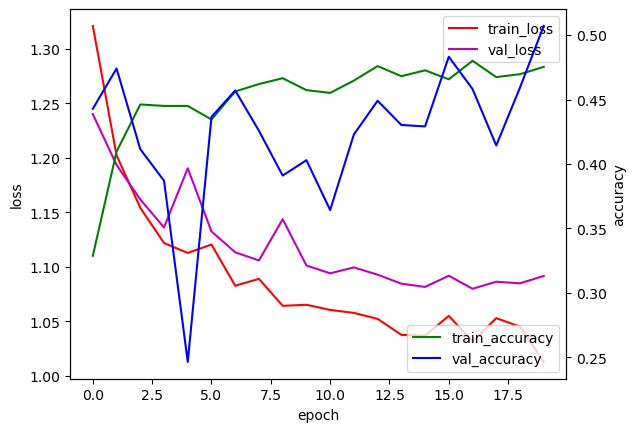

In [33]:
plot_training_progress(results_path)